### 0. IMPORITNG LIBRARIES

In [3]:
# !pip install datasets --upgrade
import datasets
import transformers
import torch
datasets.__version__, transformers.__version__, torch.__version__

('2.16.1', '4.37.2', '2.1.2+cu121')

In [4]:
import torch.nn as nn
import torch
from tqdm.auto import tqdm
import random, math, time

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

#make our work comparable if restarted the kernel
SEED = 1234
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

cuda


### 1. ETL

In [5]:
import datasets

###1. Load Dataset
task_to_keys = {
    "cola": ("sentence", None),
    "mnli": ("premise", "hypothesis"),
    "mrpc": ("sentence1", "sentence2"),
    "qnli": ("question", "sentence"),
    "qqp": ("question1", "question2"),
    "rte": ("sentence1", "sentence2"),
    "sst2": ("sentence", None),
    "stsb": ("sentence1", "sentence2"),
    "wnli": ("sentence1", "sentence2"),
}

task_name = "mnli"
raw_datasets = datasets.load_dataset("glue", task_name)
raw_datasets

DatasetDict({
    train: Dataset({
        features: ['premise', 'hypothesis', 'label', 'idx'],
        num_rows: 392702
    })
    validation_matched: Dataset({
        features: ['premise', 'hypothesis', 'label', 'idx'],
        num_rows: 9815
    })
    validation_mismatched: Dataset({
        features: ['premise', 'hypothesis', 'label', 'idx'],
        num_rows: 9832
    })
    test_matched: Dataset({
        features: ['premise', 'hypothesis', 'label', 'idx'],
        num_rows: 9796
    })
    test_mismatched: Dataset({
        features: ['premise', 'hypothesis', 'label', 'idx'],
        num_rows: 9847
    })
})

In [6]:
label_list = raw_datasets['train'].features['label'].names
label2id = {v: i for i, v in enumerate(label_list)}
label2id

{'entailment': 0, 'neutral': 1, 'contradiction': 2}

In [7]:
id2label = {i: v for v, i in label2id.items()}
id2label

{0: 'entailment', 1: 'neutral', 2: 'contradiction'}

### 2. PREPROCESSING

- ##### TOKENIZATION

In [8]:
import numpy as np 
num_labels = np.unique(raw_datasets['train']['label']).size
num_labels

3

#### model

In [9]:
from transformers import AutoModelForSequenceClassification
from transformers import AutoTokenizer

teacher_id = "bert-base-uncased"
tokenizer  = AutoTokenizer.from_pretrained(teacher_id)

teacher_model  = AutoModelForSequenceClassification.from_pretrained(
    teacher_id, 
    num_labels = num_labels,
    id2label   = id2label,
    label2id   = label2id,
)
teacher_model

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

In [10]:
def tokenize_function(examples):
    
    sentence1_key, sentence2_key = task_to_keys[task_name]
    args = (
        (examples[sentence1_key],) if sentence2_key is None else (examples[sentence1_key], examples[sentence2_key])
    )
    result = tokenizer(*args, max_length=128, truncation=True)
    return result

In [11]:
tokenized_datasets = raw_datasets.map(tokenize_function, batched=True)
tokenized_datasets

Map:   0%|          | 0/9832 [00:00<?, ? examples/s]

Map: 100%|██████████| 9832/9832 [00:00<00:00, 31752.50 examples/s]


DatasetDict({
    train: Dataset({
        features: ['premise', 'hypothesis', 'label', 'idx', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 392702
    })
    validation_matched: Dataset({
        features: ['premise', 'hypothesis', 'label', 'idx', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 9815
    })
    validation_mismatched: Dataset({
        features: ['premise', 'hypothesis', 'label', 'idx', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 9832
    })
    test_matched: Dataset({
        features: ['premise', 'hypothesis', 'label', 'idx', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 9796
    })
    test_mismatched: Dataset({
        features: ['premise', 'hypothesis', 'label', 'idx', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 9847
    })
})

In [12]:
# list(task_to_keys[task_name])
column_dataset = [item for item in task_to_keys[task_name] if item is not None]
column_dataset

['premise', 'hypothesis']

In [13]:
#remove column : 'premise', 'hypothesis', 'idx'
tokenized_datasets = tokenized_datasets.remove_columns(column_dataset + ["idx"])
#rename column : 'labels'
tokenized_datasets = tokenized_datasets.rename_column("label", "labels")
tokenized_datasets.set_format("torch")
tokenized_datasets

DatasetDict({
    train: Dataset({
        features: ['labels', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 392702
    })
    validation_matched: Dataset({
        features: ['labels', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 9815
    })
    validation_mismatched: Dataset({
        features: ['labels', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 9832
    })
    test_matched: Dataset({
        features: ['labels', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 9796
    })
    test_mismatched: Dataset({
        features: ['labels', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 9847
    })
})

In [14]:
tokenized_datasets['train'][0]['input_ids']

tensor([  101, 17158,  2135,  6949,  8301, 25057,  2038,  2048,  3937,  9646,
         1011,  4031,  1998, 10505,  1012,   102,  4031,  1998, 10505,  2024,
         2054,  2191,  6949,  8301, 25057,  2147,  1012,   102])

In [15]:
tokenizer.decode(tokenized_datasets['train'][0]['input_ids'])

'[CLS] conceptually cream skimming has two basic dimensions - product and geography. [SEP] product and geography are what make cream skimming work. [SEP]'

### 3. DATALOADER

In [16]:
from transformers import DataCollatorWithPadding
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)
#Data collator that will dynamically pad the inputs received.

In [17]:
small_train_dataset = tokenized_datasets["train"].shuffle(seed=1150).select(range(10000))
small_eval_dataset  = tokenized_datasets["validation_mismatched"].shuffle(seed=1150).select(range(1000))
small_test_dataset  = tokenized_datasets["test_mismatched"].shuffle(seed=1150).select(range(100))

In [18]:
small_eval_dataset

Dataset({
    features: ['labels', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 1000
})

In [19]:
from torch.utils.data import DataLoader
train_dataloader = DataLoader(
    small_train_dataset, shuffle=True, batch_size=32, collate_fn=data_collator)
test_dataloader = DataLoader(
    small_test_dataset, batch_size=32, collate_fn=data_collator)
eval_dataloader = DataLoader(
    small_eval_dataset, batch_size=32, collate_fn=data_collator)

In [20]:
for batch in train_dataloader:
    break
    
batch['labels'].shape, batch['input_ids'].shape, batch['attention_mask'].shape

(torch.Size([32]), torch.Size([32, 121]), torch.Size([32, 121]))

### 4. DESIGN THE MODEL

### 5.1 Teacher Model & Student Model

####  Architecture 
In the present work, the student - DistilBERT - has the same general architecture as BERT. 
- The `token-type embeddings` and the `pooler` are removed while `the number of layers` is reduced by a factor of 2. 
- Most of the operations used in the Transformer architecture `linear layer` and `layer normalisation` are highly optimized in modern linear algebra frameworks.
- our investigations showed that variations on the last dimension of the tensor (hidden size dimension) have a smaller impact on computation efficiency (for a fixed parameters budget) than variations on other factors like the number of layers. 
- Thus we focus on reducing the number of layers.

#### Initialize Student Model
- To initialize a new model from an existing one, we need to access the weights of the old model (the teacher). 
- In order to get the weights, we first have to know how to access them. We’ll use BERT as our teacher model.

In [21]:
teacher_model.config

BertConfig {
  "_name_or_path": "bert-base-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "entailment",
    "1": "neutral",
    "2": "contradiction"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "contradiction": 2,
    "entailment": 0,
    "neutral": 1
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.37.2",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

#### 
- The student model has the same configuration, except the number of layers is reduced by a factor of 2
- The student layers are initilized by copying one out of two layers of the teacher, starting with layer 0.
- The head of the teacher is also copied.

In [22]:
from transformers.models.bert.modeling_bert import BertPreTrainedModel, BertConfig
# Get teacher configuration as a dictionnary
configuration = teacher_model.config.to_dict()
# configuration

In [23]:
# Half the number of hidden layer
configuration['num_hidden_layers'] //= 2
# Convert the dictionnary to the student configuration
configuration = BertConfig.from_dict(configuration)

In [24]:
# Create uninitialized student model
model = type(teacher_model)(configuration)
model

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-5): 6 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, e

In [25]:
from transformers.models.bert.modeling_bert import BertEncoder, BertModel
from torch.nn import Module

def distill_bert_weights(
    teacher : Module,
    student : Module,
    model_type
) -> None:
    """
    Recursively copies the weights of the (teacher) to the (student).
    This function is meant to be first called on a BertFor... model, but is then called on every children of that model recursively.
    The only part that's not fully copied is the encoder, of which only half is copied.
    """
    # If the part is an entire BERT model or a BERTFor..., unpack and iterate
    if isinstance(teacher, BertModel) or type(teacher).__name__.startswith('BertFor'):
        for teacher_part, student_part in zip(teacher.children(), student.children()):
            distill_bert_weights(teacher_part, student_part,model_type)
    # Else if the part is an encoder, copy one out of every layer
    elif isinstance(teacher, BertEncoder):
        teacher_encoding_layers = [layer for layer in next(teacher.children())] #12 layers
        student_encoding_layers = [layer for layer in next(student.children())] #6 layers
        for i in range(len(student_encoding_layers)):
            if model_type == 'top':
                # Layer 1,2,3,4,5,6
                student_encoding_layers[i].load_state_dict(teacher_encoding_layers[i].state_dict())
            elif model_type == 'bot':
                # Layer 7,8,9,10,11,12
                student_encoding_layers[i].load_state_dict(teacher_encoding_layers[i+6].state_dict())
            elif model_type == 'odd':
                # Layer 1,3,5,7,9,11
                student_encoding_layers[i].load_state_dict(teacher_encoding_layers[2*i].state_dict())
            elif model_type == 'even':
                # Layer 2,4,6,8,10,12
                student_encoding_layers[i].load_state_dict(teacher_encoding_layers[(2*i) + 1].state_dict())
    # Else the part is a head or something else, copy the state_dict
    else:
        student.load_state_dict(teacher.state_dict())

    return model

In [26]:
top_k_layer_model     = distill_bert_weights(teacher=teacher_model, student=model, model_type='top')
bottom_k_layer_model  = distill_bert_weights(teacher=teacher_model, student=model, model_type='bot')
odd_layer_model       = distill_bert_weights(teacher=teacher_model, student=model, model_type='odd')
even_layer_model      = distill_bert_weights(teacher=teacher_model, student=model, model_type='even')

In [27]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [28]:
models = [teacher_model, top_k_layer_model, bottom_k_layer_model, odd_layer_model, even_layer_model]
model_names = ['Teacher', 'Top', 'Bottom', 'Odd', 'Even']

for model, name in zip(models, model_names):
    print(f'{name} parameters: {count_parameters(model)}')

Teacher parameters: 109484547
Top parameters: 66957315
Bottom parameters: 66957315
Odd parameters: 66957315
Even parameters: 66957315


In [29]:
models = [top_k_layer_model, bottom_k_layer_model, odd_layer_model, even_layer_model]
model_names = ['Top', 'Bot', 'Odd', 'Even']

teacher_params = count_parameters(teacher_model)

for model, name in zip(models, model_names):
    model_params = count_parameters(model)
    percentage = (model_params / teacher_params) * 100
    print(f'{name} model percentage of teacher: {percentage}')


Top model percentage of teacher: 61.15686353435797
Bot model percentage of teacher: 61.15686353435797
Odd model percentage of teacher: 61.15686353435797
Even model percentage of teacher: 61.15686353435797


### 5. TRAINING

- ##### LOSS FUNCTIONS

In [30]:
import torch.nn.functional as F

class DistillKL(nn.Module):
    """
    Distilling the Knowledge in a Neural Network
    Compute the knowledge-distillation (KD) loss given outputs, labels.
    "Hyperparameters": temperature and alpha

    NOTE: the KL Divergence for PyTorch comparing the softmaxs of teacher
    and student expects the input tensor to be log probabilities! 
    """

    def __init__(self):
        super(DistillKL, self).__init__()

    def forward(self, output_student, output_teacher, temperature=1):
        '''
        Note: the output_student and output_teacher are logits 
        '''
        T = temperature #.cuda()
        
        KD_loss = nn.KLDivLoss(reduction='batchmean')(
            F.log_softmax(output_student/T, dim=-1),
            F.softmax(output_teacher/T, dim=-1)
        ) * T * T
        
        return KD_loss

In [31]:
criterion_div = DistillKL()
criterion_cos = nn.CosineEmbeddingLoss()

- ##### HYPER-PARAMETERS

In [32]:
import torch.optim as optim
import torch.nn as nn

lr = 5e-5

#training hyperparameters
optimizer = optim.Adam(params=model.parameters(), lr=lr)

In [33]:
top_model  = top_k_layer_model.to(device)
bot_model  = bottom_k_layer_model.to(device)
odd_model  = odd_layer_model.to(device)
even_model = even_layer_model.to(device)
teacher_model = teacher_model.to(device)

- ##### LR SCHEDULER

In [34]:
from transformers import get_scheduler

num_epochs = 4
num_update_steps_per_epoch = len(train_dataloader)
num_training_steps = num_epochs * num_update_steps_per_epoch

lr_scheduler = get_scheduler(
    name="linear", 
    optimizer=optimizer, 
    num_warmup_steps=0, 
    num_training_steps=num_training_steps
)

- ##### METRIC

In [35]:
import numpy as np
import evaluate
# Get the metric function
if task_name is not None:
    metric = evaluate.load("glue", task_name)
else:
    metric = evaluate.load("accuracy")

- ##### TRAINING

In [36]:
import torch
from tqdm.auto import tqdm

def train(model):
    progress_bar = tqdm(range(num_training_steps))
    eval_metrics = 0

    # Lists to store losses for each epoch
    train_losses = []
    train_losses_cls = []
    train_losses_div = []
    train_losses_cos = []
    eval_losses = []

    for epoch in range(num_epochs):
        model.train()
        teacher_model.eval()
        train_loss = 0
        train_loss_cls = 0
        train_loss_div = 0
        train_loss_cos = 0
        
        for batch in train_dataloader:
            batch = {k: v.to(device) for k, v in batch.items()}
            # compute student output
            outputs = model(**batch) 
            # compute teacher output
            with torch.no_grad():
                output_teacher = teacher_model(**batch)

            # assert size
            assert outputs.logits.size() == output_teacher.logits.size()
            
            # cls loss 
            loss_cls  = outputs.loss
            train_loss_cls += loss_cls.item()
            # distillation loss
            loss_div = criterion_div(outputs.logits, output_teacher.logits)
            train_loss_div += loss_div.item()
            # cosine loss
            loss_cos = criterion_cos(output_teacher.logits, outputs.logits, torch.ones(output_teacher.logits.size()[0]).to(device))
            train_loss_cos += loss_cos.item()
            
            # Average the loss and return it
            loss = (loss_cls + loss_div + loss_cos) / 3
            
            train_loss += loss.item()
            loss.backward()
            # accelerator.backward(loss)
            # Step with optimizer
            optimizer.step()
            lr_scheduler.step()
            optimizer.zero_grad()
            progress_bar.update(1)
            
        train_losses.append(train_loss / len(train_dataloader))
        train_losses_cls.append(train_loss_cls / len(train_dataloader))
        train_losses_div.append(train_loss_div / len(train_dataloader))
        train_losses_cos.append(train_loss_cos / len(train_dataloader))

        print(f'Epoch at {epoch+1}: Train loss {train_loss/len(train_dataloader):.4f}:')
        print(f'  - Loss_cls: {train_loss_cls/len(train_dataloader):.4f}')
        print(f'  - Loss_div: {train_loss_div/len(train_dataloader):.4f}')
        print(f'  - Loss_cos: {train_loss_cos/len(train_dataloader):.4f}')
        
        model.eval()
        eval_loss = 0
        for batch in eval_dataloader:
            batch = {k: v.to(device) for k, v in batch.items()}
            with torch.no_grad():
                outputs = model(**batch)
                
            loss_cls = outputs.loss
            predictions = outputs.logits.argmax(dim=-1)

            eval_loss += loss_cls.item()
            # predictions, references = accelerator.gather((predictions, batch["labels"]))
            metric.add_batch(
                predictions=predictions, 
                references=batch["labels"])
            
        eval_metric = metric.compute()
        eval_metrics += eval_metric['accuracy'] 
        eval_losses.append(eval_loss / len(eval_dataloader))  # Save the evaluation loss for plotting
        
        print(f"Epoch at {epoch+1}: Validation Loss: {eval_loss/ len(eval_dataloader):.4f} | Validation Acc {eval_metric['accuracy']:.4f}")
        
    print('Avg Metric', eval_metrics/num_epochs)


    import matplotlib.pyplot as plt
    # Plotting
    epochs_list = range(1, num_epochs + 1)

    plt.figure(figsize=(12, 6))
    plt.plot(epochs_list, train_losses, label='Total Train Loss')
    plt.plot(epochs_list, train_losses_cls, label='Train Loss_cls')
    plt.plot(epochs_list, train_losses_div, label='Train Loss_div')
    plt.plot(epochs_list, train_losses_cos, label='Train Loss_cos')
    plt.plot(epochs_list, eval_losses, label='Validation Loss')

    plt.title('Training and Validation Losses')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

 25%|██▌       | 313/1252 [07:14<25:17,  1.62s/it]

Epoch at 1: Train loss 0.3609:
  - Loss_cls: 1.0017
  - Loss_div: 0.0351
  - Loss_cos: 0.0460
Epoch at 1: Validation Loss: 0.8664 | Validation Acc 0.6580


 50%|█████     | 626/1252 [13:15<03:07,  3.34it/s]  

Epoch at 2: Train loss 0.3147:
  - Loss_cls: 0.7977
  - Loss_div: 0.0996
  - Loss_cos: 0.0468
Epoch at 2: Validation Loss: 0.8205 | Validation Acc 0.6760


 75%|███████▌  | 939/1252 [15:11<02:10,  2.40it/s]

Epoch at 3: Train loss 0.2807:
  - Loss_cls: 0.6460
  - Loss_div: 0.1491
  - Loss_cos: 0.0471
Epoch at 3: Validation Loss: 0.8119 | Validation Acc 0.6730


100%|██████████| 1252/1252 [17:19<00:00,  2.95it/s]

Epoch at 4: Train loss 0.2623:
  - Loss_cls: 0.5673
  - Loss_div: 0.1735
  - Loss_cos: 0.0462
Epoch at 4: Validation Loss: 0.7968 | Validation Acc 0.6910
Avg Metric 0.6745


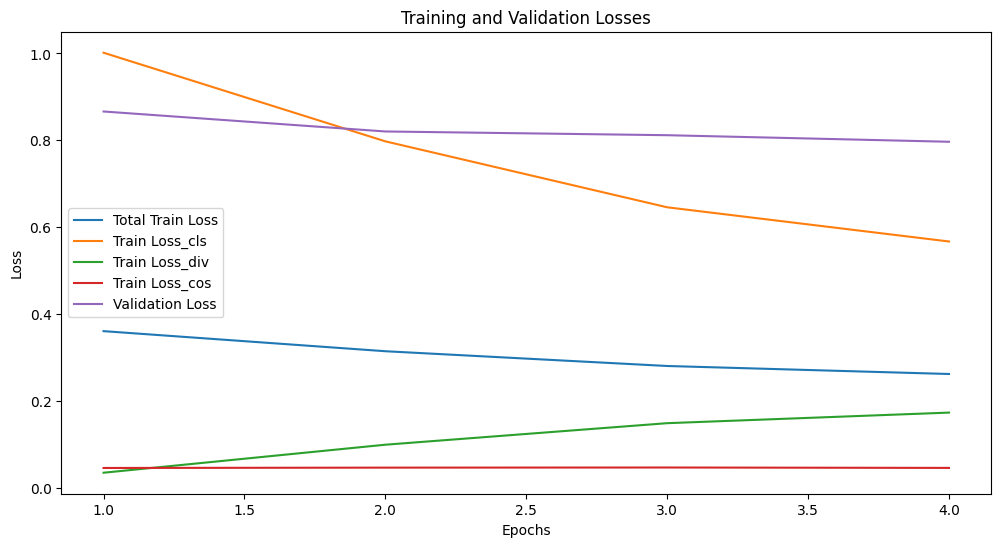

100%|██████████| 1252/1252 [17:22<00:00,  1.20it/s]


In [37]:
train(top_k_layer_model)

 25%|██▌       | 313/1252 [01:52<05:55,  2.64it/s]

Epoch at 1: Train loss 0.2562:
  - Loss_cls: 0.5443
  - Loss_div: 0.1791
  - Loss_cos: 0.0453
Epoch at 1: Validation Loss: 0.7968 | Validation Acc 0.6910


 50%|█████     | 626/1252 [03:56<03:50,  2.72it/s]

Epoch at 2: Train loss 0.2565:
  - Loss_cls: 0.5451
  - Loss_div: 0.1787
  - Loss_cos: 0.0457
Epoch at 2: Validation Loss: 0.7968 | Validation Acc 0.6910


 75%|███████▌  | 939/1252 [05:59<01:52,  2.79it/s]

Epoch at 3: Train loss 0.2562:
  - Loss_cls: 0.5427
  - Loss_div: 0.1807
  - Loss_cos: 0.0453
Epoch at 3: Validation Loss: 0.7968 | Validation Acc 0.6910


100%|██████████| 1252/1252 [08:00<00:00,  3.13it/s]

Epoch at 4: Train loss 0.2569:
  - Loss_cls: 0.5466
  - Loss_div: 0.1789
  - Loss_cos: 0.0454
Epoch at 4: Validation Loss: 0.7968 | Validation Acc 0.6910
Avg Metric 0.691


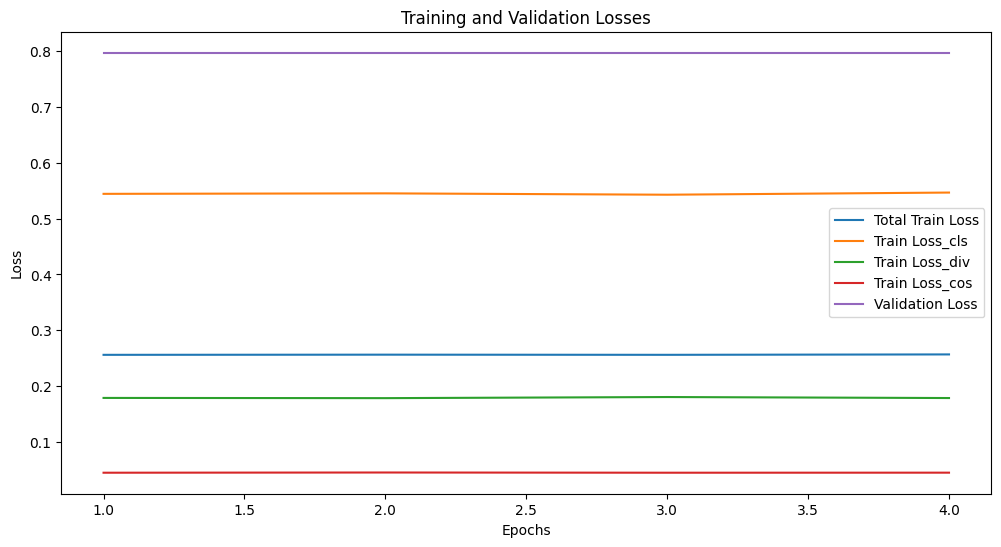

100%|██████████| 1252/1252 [08:02<00:00,  2.59it/s]


In [38]:
train(bottom_k_layer_model)

 25%|██▌       | 313/1252 [01:46<05:05,  3.08it/s]

Epoch at 1: Train loss 0.2564:
  - Loss_cls: 0.5439
  - Loss_div: 0.1798
  - Loss_cos: 0.0454
Epoch at 1: Validation Loss: 0.7968 | Validation Acc 0.6910


 50%|█████     | 626/1252 [03:48<04:12,  2.48it/s]

Epoch at 2: Train loss 0.2571:
  - Loss_cls: 0.5466
  - Loss_div: 0.1794
  - Loss_cos: 0.0452
Epoch at 2: Validation Loss: 0.7968 | Validation Acc 0.6910


 75%|███████▌  | 939/1252 [06:11<02:00,  2.60it/s]

Epoch at 3: Train loss 0.2564:
  - Loss_cls: 0.5432
  - Loss_div: 0.1805
  - Loss_cos: 0.0456
Epoch at 3: Validation Loss: 0.7968 | Validation Acc 0.6910


100%|██████████| 1252/1252 [08:35<00:00,  1.92it/s]

Epoch at 4: Train loss 0.2568:
  - Loss_cls: 0.5448
  - Loss_div: 0.1800
  - Loss_cos: 0.0456
Epoch at 4: Validation Loss: 0.7968 | Validation Acc 0.6910
Avg Metric 0.691


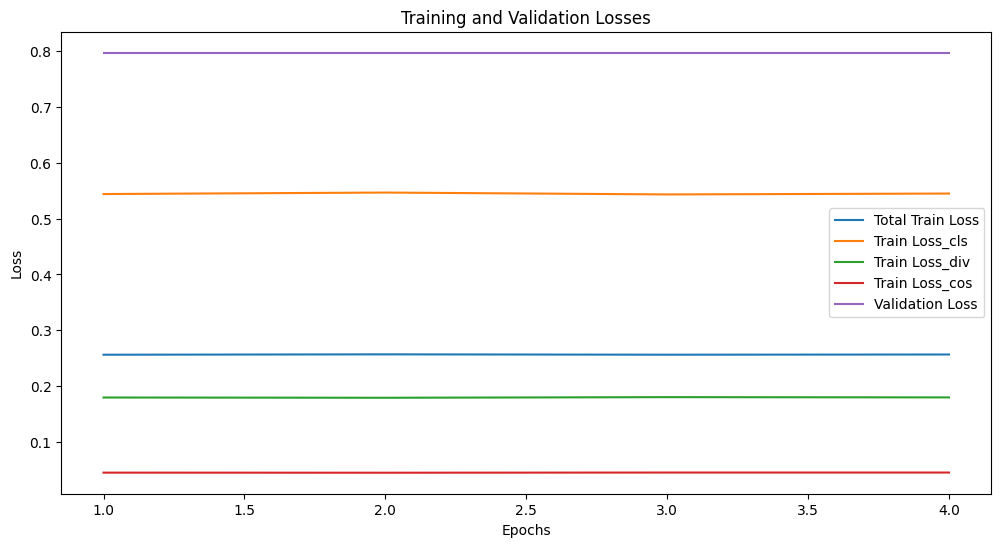

100%|██████████| 1252/1252 [08:39<00:00,  2.41it/s]


In [39]:
train(odd_layer_model)

 25%|██▌       | 313/1252 [02:03<06:06,  2.56it/s]

Epoch at 1: Train loss 0.2566:
  - Loss_cls: 0.5445
  - Loss_div: 0.1802
  - Loss_cos: 0.0451
Epoch at 1: Validation Loss: 0.7968 | Validation Acc 0.6910


 50%|█████     | 626/1252 [04:25<03:55,  2.66it/s]

Epoch at 2: Train loss 0.2564:
  - Loss_cls: 0.5434
  - Loss_div: 0.1806
  - Loss_cos: 0.0452
Epoch at 2: Validation Loss: 0.7968 | Validation Acc 0.6910


 75%|███████▌  | 939/1252 [06:48<02:04,  2.52it/s]

Epoch at 3: Train loss 0.2570:
  - Loss_cls: 0.5453
  - Loss_div: 0.1802
  - Loss_cos: 0.0454
Epoch at 3: Validation Loss: 0.7968 | Validation Acc 0.6910


100%|██████████| 1252/1252 [09:02<00:00,  2.20it/s]

Epoch at 4: Train loss 0.2567:
  - Loss_cls: 0.5450
  - Loss_div: 0.1800
  - Loss_cos: 0.0451
Epoch at 4: Validation Loss: 0.7968 | Validation Acc 0.6910
Avg Metric 0.691


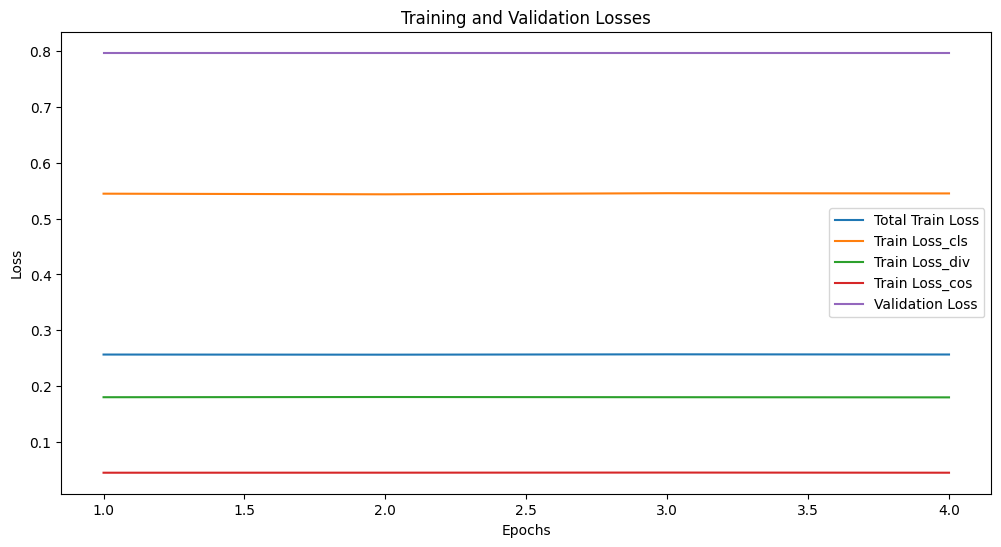

100%|██████████| 1252/1252 [09:05<00:00,  2.29it/s]


In [40]:
train(even_layer_model)

### 6. APPENDIX (TEACHER MODEL)

In [41]:
import torch
from tqdm.auto import tqdm
import torch.optim as optim
import torch.nn as nn

lr = 5e-5
#training hyperparameters
optimizer = optim.Adam(params=teacher_model.parameters(), lr=lr)

progress_bar = tqdm(range(num_training_steps))
eval_metrics = 0

for epoch in range(num_epochs):
    teacher_model.train()
    train_loss = 0
    for step, batch in enumerate(train_dataloader):
        batch = {k: v.to(device) for k, v in batch.items()}
        output_teacher = teacher_model(**batch)
        # cls loss 
        loss = output_teacher.loss
        train_loss += loss.item()
        loss.backward()
        # accelerator.backward(loss)
        # Step with optimizer
        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()
        progress_bar.update(1)

    print(f'Epoch at {epoch+1}: Train loss {train_loss/len(train_dataloader):.4f}:')
    
    teacher_model.eval()
    for step, batch in enumerate(eval_dataloader):
        batch = {k: v.to(device) for k, v in batch.items()}
        with torch.no_grad():
            outputs = teacher_model(**batch)
    
        predictions = outputs.logits.argmax(dim=-1)
        # predictions, references = accelerator.gather((predictions, batch["labels"]))
        metric.add_batch(
            predictions=predictions, 
            references=batch["labels"])
        
    eval_metric = metric.compute()
    eval_metrics += eval_metric['accuracy'] 
    print(f"Epoch at {epoch+1}: Test Acc {eval_metric['accuracy']:.4f}")
    
print('Avg Metric', eval_metrics/num_epochs)


  1%|          | 12/1252 [00:04<07:46,  2.66it/s]

OutOfMemoryError: CUDA out of memory. Tried to allocate 48.00 MiB. GPU 0 has a total capacty of 5.79 GiB of which 55.00 MiB is free. Including non-PyTorch memory, this process has 5.26 GiB memory in use. Of the allocated memory 4.65 GiB is allocated by PyTorch, and 481.81 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF